In [163]:
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [164]:
df = pd.read_csv('sensor_data.csv')

In [165]:
# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set the index to be the 'timestamp' column
df.set_index('timestamp', inplace=True)

# Resample the data to hourly averages
temperature_df_hourly = df['temperature'].resample('H').mean()
humidity_df_hourly = df['humidity'].resample('H').mean()

# Drop any missing values
temperature_df_hourly.dropna(inplace=True)
humidity_df_hourly.dropna(inplace=True)
# Display the first few rows
temperature_df_hourly.head()

timestamp
2024-09-27 18:00:00    30.127857
2024-09-27 20:00:00    28.535603
2024-09-27 21:00:00    28.144222
2024-09-27 22:00:00    27.984500
2024-09-27 23:00:00    27.931667
Name: temperature, dtype: float64

In [166]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Split data into training and testing sets
train_size = int(len(temperature_df_hourly) * 0.7)
temperature_train = temperature_df_hourly[:train_size]
temperature_test = temperature_df_hourly[train_size:]

In [167]:
# Fit an ARIMA model
model = ARIMA(temperature_train, order=(5, 1, 0))
model_fit = model.fit()
# Make a forecast
forecast = model_fit.forecast(steps=len(temperature_test))


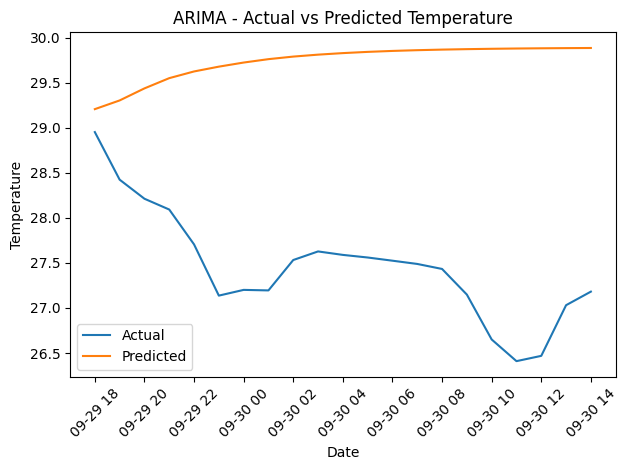

ARIMA - MAE: 2.2777785477196764, MSE: 5.784905241971222, MAPE: 0.08360662521862088


In [168]:
# Plot actual vs predicted values
plt.plot(temperature_test.index, temperature_test, label='Actual')
plt.plot(temperature_test.index, forecast, label='Predicted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARIMA - Actual vs Predicted Temperature')
plt.legend()

plt.tight_layout()

plt.show()

# Calculate metrics
mae = mean_absolute_error(temperature_test, forecast)
mse = mean_squared_error(temperature_test, forecast)
mape = mean_absolute_percentage_error(temperature_test, forecast)
print(f"ARIMA - MAE: {mae}, MSE: {mse}, MAPE: {mape}")

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [170]:
## Fit a SARIMAX model
model_sar = SARIMAX(temperature_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit_sar = model_sar.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.73972D-01    |proj g|=  7.49549D-01

At iterate    5    f=  3.83664D-01    |proj g|=  5.45700D-02

At iterate   10    f=  3.78448D-01    |proj g|=  3.92591D-02


 This problem is unconstrained.



At iterate   15    f=  3.72697D-01    |proj g|=  7.91036D-03

At iterate   20    f=  3.72614D-01    |proj g|=  5.01022D-04

At iterate   25    f=  3.72611D-01    |proj g|=  1.04052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   1.041D-04   3.726D-01
  F =  0.37261118486053341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [171]:
# Forecast
forecast_sar = model_fit_sar.forecast(steps=len(temperature_test))

In [172]:
 #Make a forecast
forecast = model_fit.forecast(steps=len(temperature_test))

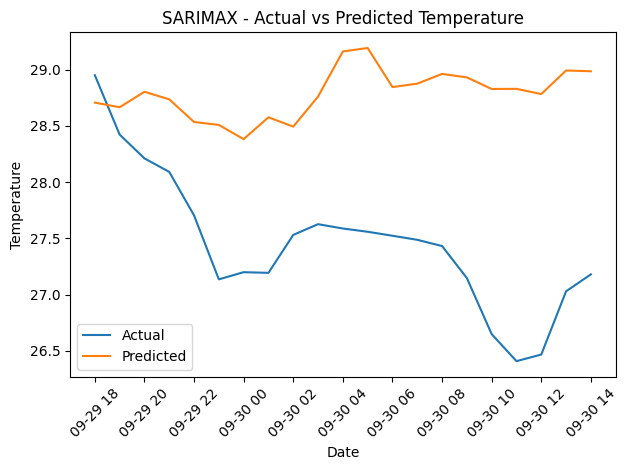

In [173]:
# Plot actual vs predicted values
plt.plot(temperature_test.index, temperature_test, label='Actual')
plt.plot(temperature_test.index, forecast_sar, label='Predicted')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('SARIMAX - Actual vs Predicted Temperature')

plt.legend()

plt.tight_layout()

plt.show()

In [174]:
# Calculate metrics
mae_sar = mean_absolute_error(temperature_test, forecast_sar)
mse_sar = mean_squared_error(temperature_test, forecast_sar)
mape_sar = mean_absolute_percentage_error(temperature_test, forecast_sar)
print(f"SARIMAX - MAE: {mae_sar}, MSE: {mse_sar}, MAPE: {mape_sar}")

SARIMAX - MAE: 1.3568779397354596, MSE: 2.2083670904184647, MAPE: 0.04989257037667431


In [175]:
from keras.models import Sequential
from keras.layers import Dense, LSTM



In [176]:
# Normalize the temperature data
mean = temperature_df_hourly.mean()
std = temperature_df_hourly.std()
temperature_normalized = (temperature_df_hourly - mean) / std

In [177]:
# Create the LSTM input sequence
look_back = 24  # Use the last 24 hours
X = []
y = []
for i in range(look_back, len(temperature_normalized)):
    X.append(temperature_normalized[i - look_back:i])
    y.append(temperature_normalized[i])

X = np.array(X)
y = np.array(y)

In [178]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape the input data for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [179]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [180]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.6228
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6093
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 0.5962
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 0.5833
Epoch 5/100
1/1 [==============================] - 0s 23ms/step - loss: 0.5707
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.5583
Epoch 7/100
1/1 [==============================] - 0s 29ms/step - loss: 0.5459
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.5336
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 0.5213
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - loss: 0.5090
Epoch 11/100
1/1 [==============================] - 0s 32ms/step - loss: 0.4965
Epoch 12/100
1/1 [==============================] - 0s 26ms/step - loss: 0.4839
Epoch 13/100
1/1 [==============================] -

In [181]:
# Predict future values
forecast_lstm = model.predict(X_test)

1/1 [==============================] - 0s 294ms/step


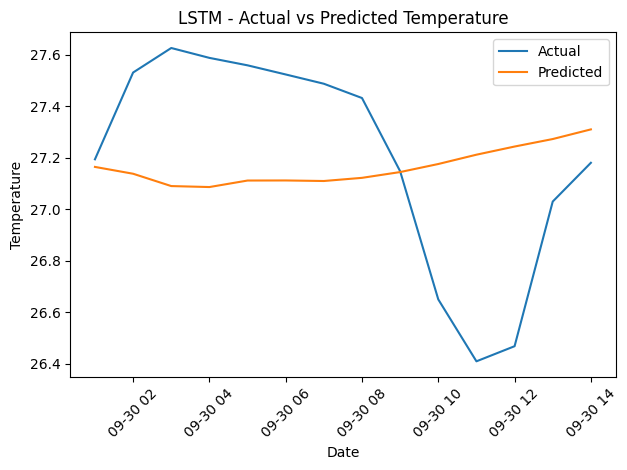

In [182]:
# Denormalize the forecasted values
forecast_denormalized = forecast_lstm * std + mean
y_test_denormalized = y_test * std + mean

# Use the same index for plotting (so both y_test and forecast align)
time_index = temperature_df_hourly.index[-len(y_test):]

# Plot actual vs predicted values
plt.plot(time_index, y_test_denormalized, label='Actual')
plt.plot(time_index, forecast_denormalized, label='Predicted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('LSTM - Actual vs Predicted Temperature')

plt.legend()

plt.tight_layout()
plt.show()

In [183]:
# Calculate metrics
mae_lstm = mean_absolute_error(y_test_denormalized, forecast_denormalized)
mse_lstm = mean_squared_error(y_test_denormalized, forecast_denormalized)
mape_lstm = mean_absolute_percentage_error(y_test_denormalized, forecast_denormalized)
print(f"LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, MAPE: {mape_lstm}")

LSTM - MAE: 0.39200226135733934, MSE: 0.20728304959222982, MAPE: 0.014465899522142837


In [184]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

 #Normalize the temperature data
mean = temperature_df_hourly.mean()
std = temperature_df_hourly.std()
temperature_normalized = (temperature_df_hourly - mean) / std


In [185]:
# Create the RNN input sequence
look_back = 24  # Use the last 24 hours
X = []
y = []
for i in range(look_back, len(temperature_normalized)):
    X.append(temperature_normalized[i - look_back:i])
    y.append(temperature_normalized[i])


In [186]:
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape the input data for the RNN model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [187]:
# Define the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(look_back, 1)))  # Replaced LSTM with SimpleRNN
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
1/1 [==============================] - 1s 664ms/step - loss: 0.6015
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.4732
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 0.3746
Epoch 4/100
1/1 [==============================] - 0s 22ms/step - loss: 0.3011
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: 0.2479
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.2103
Epoch 7/100
1/1 [==============================] - 0s 19ms/step - loss: 0.1840
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: 0.1656
Epoch 9/100
1/1 [==============================] - 0s 23ms/step - loss: 0.1521
Epoch 10/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1415
Epoch 11/100
1/1 [==============================] - 0s 20ms/step - loss: 0.1324
Epoch 12/100
1/1 [==============================] - 0s 18ms/step - loss: 0.1240
Epoch 13/100
1/1 [==============================]

In [188]:
# Predict future values
forecast_rnn = model.predict(X_test)



1/1 [==============================] - 0s 109ms/step


In [189]:
# Denormalize the forecasted values
forecast_denormalized = forecast_rnn * std + mean
y_test_denormalized = y_test * std + mean

# Use the same index for plotting (so both y_test and forecast align)
time_index = temperature_df_hourly.index[-len(y_test):]

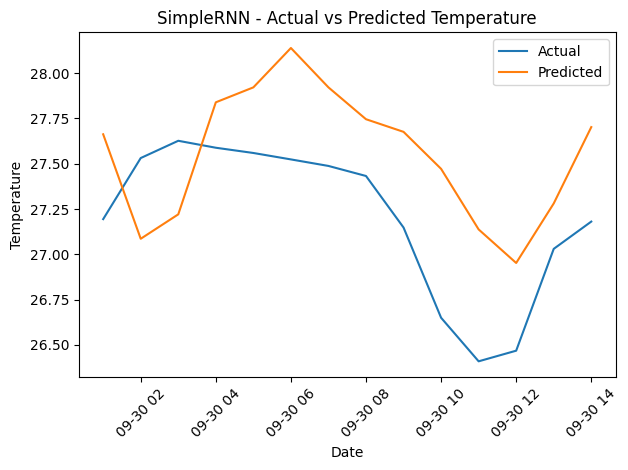

In [190]:
# Plot actual vs predicted values
plt.plot(time_index, y_test_denormalized, label='Actual')
plt.plot(time_index, forecast_denormalized, label='Predicted')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('SimpleRNN - Actual vs Predicted Temperature')

plt.legend()

plt.tight_layout()
plt.show()

In [191]:
# Calculate metrics
mae_rnn = mean_absolute_error(y_test_denormalized, forecast_denormalized)
mse_rnn = mean_squared_error(y_test_denormalized, forecast_denormalized)
mape_rnn = mean_absolute_percentage_error(y_test_denormalized, forecast_denormalized)
print(f"SimpleRNN - MAE: {mae_rnn}, MSE: {mse_rnn}, MAPE: {mape_rnn}")


SimpleRNN - MAE: 0.47344440495213086, MSE: 0.2495582581743318, MAPE: 0.017460772919726062
